## How much data do we need to create human-compatible policies?

In [9]:
from utils.config import load_config_nb
from utils.policies import load_policy
from evaluation.policy_evaluation import evaluate_policy
import pickle
from utils.sb3.reg_ppo import RegularizedPPO
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
mpl.rcParams['lines.linewidth'] = 2

sns.set('notebook', font_scale=1.1, rc={'figure.figsize': (10, 5)})
sns.set_style('ticks', rc={'figure.facecolor': 'none', 'axes.facecolor': 'none'})
%config InlineBackend.figure_format = 'svg'
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')

models_config = load_config_nb("model_config")

### Load df with # intersecting paths per scene

In [10]:
# Load dict with number of intersecting paths per scene
with open('../evaluation/scene_info/valid_all_01_23_11_18.pkl', 'rb') as handle:
    scene_to_paths_dict = pickle.load(handle)

# Create an empty dataframe
df_intersect = pd.DataFrame(columns=['traffic_scene', 'veh_id', 'intersecting_paths'])

# Populate the dataframe
for traffic_scene, data in scene_to_paths_dict.items():
    veh_ids = data['veh_id']
    intersecting_paths = data['intersecting_paths']

    # Repeat traffic_scene for each veh_id
    traffic_scene_col = [traffic_scene] * len(veh_ids)

    # Append to the dataframe
    df_intersect = pd.concat([df_intersect, pd.DataFrame(list(zip(traffic_scene_col, veh_ids, intersecting_paths)), columns=['traffic_scene', 'veh_id', 'intersecting_paths'])])

# Reset index
df_intersect.reset_index(drop=True, inplace=True)

### Configurations

In [11]:
# Settings
DETERMINISTIC = True 
SELECT_FROM = 10_000
NUM_EVAL_EPISODES = 1000
CONTROLLED_AGENTS = 1 # Evaluate all policies in log-replay mode
METRICS = ['goal_rate', 'off_road', 'veh_veh_collision']

TEST_DATA_PATH = '../data_full/valid'

env_config = load_config_nb("env_config")

### Evaluate BC policies

In [ ]:
df_bc = pd.DataFrame()

for model_config in models_config.small_data_il:
    
    print(f'model_name: {model_config.name}')
    
    # Load policy    
    human_policy = load_policy(
        data_path=f"../{models_config.small_data_bc_models_dir}",
        file_name=model_config.name, 
    )

    # Evaluate policy
    df_res_bc = evaluate_policy(
        env_config=env_config,
        controlled_agents=1,
        data_path=TEST_DATA_PATH,
        mode='policy',
        policy=human_policy,
        select_from_k_scenes=SELECT_FROM,
        num_episodes=NUM_EVAL_EPISODES,
        scene_path_mapping=scene_to_paths_dict,
    )
    
    # Add identifiers
    df_res_bc['model_name'] = np.repeat(model_config.name, len(df_res_bc))
    df_res_bc['data_size'] = np.repeat(model_config.samples, len(df_res_bc))

    # Store
    df_bc = pd.concat([df_bc, df_res_bc], ignore_index=True)

### Load results df

In [15]:
df_hr_ppo = pd.read_csv('../evaluation/paper/df_small_data_0131.csv')

In [16]:
df_hr_ppo

,scene_id,veh_id,num_total_vehs,veh_int_paths,tot_int_paths,goal_rate,off_road,veh_veh_collision,model_name,data_size,Agent
0,tfrecord-00033-of-00150_109.json,22,8,0.0,0.0,0.0,0.0,1.0,policy_L0.0_S1000_I1212,0,PPO
1,tfrecord-00053-of-00150_20.json,10,8,0.0,1.0,1.0,0.0,0.0,policy_L0.0_S1000_I1212,0,PPO
2,tfrecord-00031-of-00150_177.json,3,11,0.0,0.0,1.0,0.0,0.0,policy_L0.0_S1000_I1212,0,PPO
3,tfrecord-00097-of-00150_114.json,12,2,0.0,0.0,1.0,0.0,0.0,policy_L0.0_S1000_I1212,0,PPO
4,tfrecord-00022-of-00150_46.json,4,3,0.0,0.0,1.0,0.0,0.0,policy_L0.0_S1000_I1212,0,PPO
...,...,...,...,...,...,...,...,...,...,...,...
3995,tfrecord-00081-of-00150_132.json,23,1,0.0,0.0,0.0,0.0,1.0,policy_L0.02_S1000_I1750_S436_FILTERED,100000,HR-PPO
3996,tfrecord-00045-of-00150_36.json,30,2,0.0,0.0,1.0,0.0,0.0,policy_L0.02_S1000_I1750_S436_FILTERED,100000,HR-PPO
3997,tfrecord-00104-of-00150_189.json,7,2,1.0,1.0,1.0,0.0,0.0,policy_L0.02_S1000_I1750_S436_FILTERED,100000,HR-PPO
3998,tfrecord-00120-of-00150_281.json,2,26,1.0,2.0,0.0,0.0,1.0,policy_L0.02_S1000_I1750_S436_FILTERED,100000,HR-PPO


### Make aggregate table

In [17]:
BINS = [-1, 0, 1, 2, float('inf')]
LABELS = ['0', '1', '2', '3+']

# Group self play results
# df_bc['int_path_cat'] = pd.cut(df_bc['veh_int_paths'], bins=BINS, labels=LABELS, include_lowest=True)

# df_agg_bc = df_bc.groupby(['data_size', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
# df_agg_bc['goal_rate'] = df_agg_bc['goal_rate'] * 100
# df_agg_bc['off_road'] = df_agg_bc['off_road'] * 100
# df_agg_bc['veh_veh_collision'] = df_agg_bc['veh_veh_collision'] * 100

# Group self play results
df_hr_ppo['int_path_cat'] = pd.cut(df_hr_ppo['veh_int_paths'], bins=BINS, labels=LABELS, include_lowest=True)
df_agg_hr_ppo = df_hr_ppo.groupby(['data_size', 'int_path_cat'])[['goal_rate', 'off_road', 'veh_veh_collision']].mean()
df_agg_hr_ppo['goal_rate'] = df_agg_hr_ppo['goal_rate'] * 100
df_agg_hr_ppo['off_road'] = df_agg_hr_ppo['off_road'] * 100
df_agg_hr_ppo['veh_veh_collision'] = df_agg_hr_ppo['veh_veh_collision'] * 100

In [18]:
df_agg_hr_ppo

goal_rate   off_road  veh_veh_collision
data_size int_path_cat                                         
0         0             78.318003   2.759527          20.367937
          1             58.988764   6.179775          30.898876
          2             42.105263   2.631579          55.263158
          3+            52.173913   0.000000          39.130435
5000      0             80.420499   3.416557          14.191853
          1             64.606742   6.741573          21.348315
          2             50.000000   2.631579          42.105263
          3+            60.869565   0.000000          30.434783
20000     0             80.551905   3.416557          16.688568
          1             65.730337   5.617978          24.719101
          2             50.000000   2.631579          42.105263
          3+            69.565217   0.000000          30.434783
100000    0             77.266754   5.519054          17.871222
          1             65.168539  10.674157          23.595506
          2             42.105263  10.526316          39.473684
          3+            52.173913   4.347826          39.130435

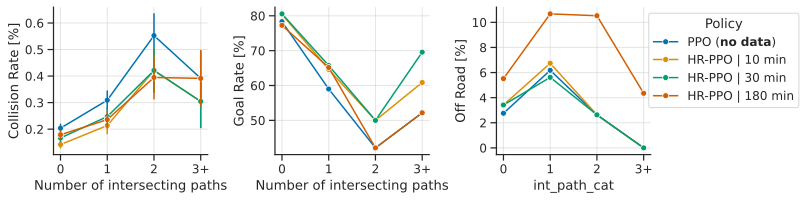

In [25]:
df_hr_ppo_reset = df_agg_hr_ppo.reset_index()
#df_bc_reset = df_agg_bc.reset_index()

df_hr_ppo_reset['data_size'] = df_hr_ppo_reset['data_size'].replace({0: r'PPO ($\bf{no \,\, data}$)', 5000: 'HR-PPO | 10 min', 20000: 'HR-PPO | 30 min', 100000: 'HR-PPO | 180 min'})

fig, axs = plt.subplots(1, 3, figsize=(12, 3))

# PPO
sns.lineplot(
    x='int_path_cat', 
    y='veh_veh_collision', 
    data=df_hr_ppo,
    hue='data_size',
    ax=axs[0],
    palette='colorblind',
    marker='o',
    errorbar='se',
    err_style='bars',
    legend=False,
)

# BC Baseline
# sns.lineplot(
#     x='int_path_cat', 
#     y='veh_veh_collision', 
#     data=df_bc_reset[df_bc_reset['data_size'] == 100_000],
#     ax=axs[0],
#     c='lightblue',
#     marker='o',
#     label='BC',
#     legend=False,
# )

# PPO
sns.lineplot(
    x='int_path_cat', 
    y='goal_rate', 
    data=df_hr_ppo_reset,
    hue='data_size',
    palette='colorblind',
    ax=axs[1],
    marker='o',
    legend=False,
)

# BC Baseline
# sns.lineplot(
#     x='int_path_cat', 
#     y='goal_rate', 
#     data=df_bc_reset[df_bc_reset['data_size'] == 100_000],
#     ax=axs[1],
#     c='lightblue',
#     marker='o',
#     label='BC',
#     legend=False,
# )

# PPO
sns.lineplot(
    x='int_path_cat', 
    y='off_road', 
    data=df_hr_ppo_reset,
    hue='data_size',
    palette='colorblind',
    ax=axs[2],
    marker='o',
)

# BC Baseline
# sns.lineplot(
#     x='int_path_cat', 
#     y='off_road', 
#     data=df_bc_reset[df_bc_reset['data_size'] == 100_000],
#     ax=axs[2],
#     c='lightblue',
#     marker='o',
#     label='BC',
#     legend=False,
# )


axs[0].set_ylabel('Collision Rate [%]')
axs[0].set_xlabel('Number of intersecting paths')

axs[1].set_ylabel('Goal Rate [%]')
axs[1].set_xlabel('Number of intersecting paths')
axs[2].set_ylabel('Off Road [%]')
axs[2].legend(title='Policy', loc='upper right', bbox_to_anchor=(2.0, 1), facecolor='white')

fig.subplots_adjust(bottom=0.25)
axs[1].grid(True, alpha=0.5), axs[0].grid(True, alpha=0.5), axs[2].grid(True, alpha=0.5),
sns.despine()
plt.tight_layout()

plt.savefig(f'../evaluation/figures/small_data_big_results.pdf', bbox_inches="tight")